In [84]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, BatchNormalization
from common import sns_cm, plot_loss_accuracy, get_set
from keras.callbacks import EarlyStopping
import pandas as pd
import math
import tensorflow as tf
from pathlib import Path
import numpy as np

In [85]:
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

#### Parses the model names.

In [86]:
def parse_key(title):
    parts = title.split(", ")
    
    # Parse the key to get the number of neurons, layers, and timesteps
    neuron = int(parts[0].split(": ")[1])
    layer = int(parts[1].split(": ")[1])
    timestep = int(parts[2].split(": ")[1])
    
    return neuron, layer, timestep

### A callback to stop training if accuracy > 98% and loss < 20%

In [87]:
def map_to_100(data, return_data=False):
    count = math.floor(data['class'].value_counts().min() / 100) * 100
    balanced_data = data.groupby('class').apply(lambda x: x.sample(count)).reset_index(drop=True)
    return (balanced_data.drop('class', axis='columns').to_numpy(), pd.get_dummies(balanced_data['class'], columns=['class']).to_numpy()) if not return_data else balanced_data

### Get data from Per files

In [88]:
def process_data(path):
    data_list = []
    for _class in Path(path).rglob("*"):
        temp_df = pd.read_pickle(str(_class))
        temp_df['class'] = str(_class.name)[:-1]
        data_list.append(temp_df)
    return data_list

In [89]:
class_mapping = {
    "Jump": "Jumping_Per",
    "Running": "Running_Per",
    "Walk": "Walking_Per",
    "Spinning": "Spinning_Per"
}

per_train = pd.concat(process_data("Per/training"), axis='rows', ignore_index=True)
per_test = pd.concat(process_data("Per/test"), axis='rows', ignore_index=True)

per_train['class'] = per_train['class'].replace(class_mapping)
per_test['class'] = per_test['class'].replace(class_mapping)

### Get data from my files

In [90]:
movement_positions: list[str] = ['Squats', 'Jumping', 'Running', 'Walking']

testing_set = pd.concat(get_set(positions=movement_positions, folder='Test'), axis='rows', ignore_index=True)
df = pd.concat(get_set(positions=movement_positions, folder='Class Dataframes'), axis='rows', ignore_index=True)

In [0]:
data_file = pd.read_pickle("neural_test_set.pkl")

In [117]:
per_data_file = pd.read_pickle("Per/Combined1")

In [118]:
per_data_file

,ax,ay,az,gx,gy,gz
0,4.558471,-6.820117,2.995271,-0.757523,-0.027076,0.143957
1,4.450844,-7.386989,3.086731,-0.675923,-0.062464,0.118707
2,4.447851,-7.635622,2.974315,-0.571076,-0.265891,0.135045
3,4.176914,-7.633077,2.746040,-0.494191,-0.546194,0.209427
4,3.452271,-7.565418,2.194137,-0.440995,-0.831833,0.341502
...,...,...,...,...,...,...
5984,-9.857152,-13.685740,-3.326532,3.345347,1.987068,0.014266
5985,-11.035352,-11.197465,-2.332599,3.074797,1.397814,-0.179475
5986,-9.910291,-8.462802,-1.788780,2.590031,0.866544,-0.496357
5987,-6.596333,-6.511459,-1.863475,1.899447,0.674983,-0.905827


### Data

In [92]:
training_df = map_to_100(pd.concat([df, per_train], axis='rows', ignore_index=True), True)
X_test, y_test = map_to_100(pd.concat([testing_set, per_test], axis='rows', ignore_index=True))
X_new, y_new = map_to_100(data_file)

In [93]:
training_df

,ax,ay,az,gx,gy,gz,class
0,-1.274178,-0.770788,0.086740,-1.401589,-0.491274,0.163249,Jumping
1,-0.500698,-1.654039,-4.682156,1.632031,-0.716066,-0.085977,Jumping
2,-0.713958,-0.531207,-1.881058,-0.965444,-0.509599,0.120490,Jumping
3,4.483850,-3.444767,0.539282,-1.362495,-0.039247,-0.176382,Jumping
4,-2.655435,-5.262116,-0.707976,0.281142,0.884812,0.117283,Jumping
...,...,...,...,...,...,...,...
23995,0.951571,-10.492131,1.028661,-0.190262,-0.932500,-0.065497,Walking_Per
23996,5.609884,-10.967842,-0.870889,0.119976,-0.213866,0.258170,Walking_Per
23997,5.303771,-10.636132,2.520159,1.377401,1.107226,-0.228685,Walking_Per
23998,3.755540,-7.010222,0.485740,-0.406545,-1.235425,0.091001,Walking_Per


In [94]:
training_df['class'].value_counts()

class
Jumping         3000
Jumping_Per     3000
Running         3000
Running_Per     3000
Spinning_Per    3000
Squats          3000
Walking         3000
Walking_Per     3000
Name: count, dtype: int64

### Class labels

In [95]:
classes = movement_positions + list(class_mapping.values())

# Reshaping training, testing data

In [96]:
def reshape_test(window_size, _X_test, _Y_test):
    number_of_windows_test = _X_test.shape[0]//window_size
    number_of_features_test = _X_test.shape[1]
    n_frames = window_size*number_of_windows_test

    y_test_window = _Y_test[:n_frames,:]
    X_test_window = _X_test[:n_frames,:]
    X_test_window = np.reshape(X_test_window, (number_of_windows_test, window_size, number_of_features_test))

    y_test_window = np.reshape(y_test_window, (number_of_windows_test, window_size, 8)).mean(axis=1)

    return X_test_window, y_test_window

In [97]:
def reshape_train(x, y, x_valid, y_valid, window_size):
    number_of_windows_train = x.shape[0]//window_size
    number_of_features_train = x.shape[1]

    number_of_windows_valid = x_valid.shape[0]//window_size
    number_of_features_valid = x_valid.shape[1]

    n_frames = window_size*number_of_windows_train
    X_train_window = x[:n_frames,:]
    y_train_window = y[:n_frames,:]

    n_frames_valid = window_size*number_of_windows_valid
    X_train_valid_window = x_valid[:n_frames_valid,:]
    y_train_valid_window = y_valid[:n_frames_valid,:]

    X_train_window = np.reshape(X_train_window, (number_of_windows_train, window_size, number_of_features_train))
    X_train_valid_window = np.reshape(X_train_valid_window, (number_of_windows_valid, window_size, number_of_features_valid))

    y_train_window = np.reshape(y_train_window, (number_of_windows_train, window_size, 8)).mean(axis=1)
    y_train_valid_window = np.reshape(y_train_valid_window, (number_of_windows_valid, window_size, 8)).mean(axis=1)

    return X_train_window, y_train_window, X_train_valid_window, y_train_valid_window

## Classification of the four movement classes

### You should use RNN as a classifier. To save time we will just use the GRU neuron. Hyperparameters you can change for optimizing are:
##### — Number of neurons in each layer. You need to provide result for at least three different sizes of a layer
##### — Number of layers. We can limit ourself to 1 and 2 layers.
##### — Window length, You need to provide result for at least 3 different window lengths
##### This does mean that you need to train 2 x 3 x 3 models.

### This will extract 500 samples from each class, combines to provide a validation set

In [98]:
def train_val_split(_df, samples=500):
    # Get unique classes
    classes = _df['class'].unique()

    class_dfs = {}

    for class_name in classes:
        # Select n rows of the current class
        class_df = _df[_df['class'] == class_name].sample(n=samples)

        # Save these rows to a dictionary
        class_dfs[class_name] = class_df

        # Delete these rows from the original dataframe
        #_df = _df.drop(class_df.index)
        _df.drop(class_df.index, inplace=True)

    # Reset index in the updated dataframe
    _df.reset_index(drop=True, inplace=True)

    # Merge class_dfs into one dataframe and reset its index
    merged_df = pd.concat(class_dfs.values()).reset_index(drop=True)

    return _df.drop('class', axis='columns').to_numpy(), pd.get_dummies(_df['class'],
                                                                        columns=['class']).to_numpy(), merged_df.drop(
        'class', axis='columns').to_numpy(), pd.get_dummies(merged_df['class'], columns=['class']).to_numpy()


### Hyperparameters

In [99]:
neurons = [20, 40, 60, 80, 100]
layers = [1, 2, 3, 4, 5]
time_steps = [25, 50, 100, 150, 200]  # Number of previous time steps used to predict each step.
training_scores = {}

### Model information

In [100]:
models = {}
histories = {}

### Contains training, testing, raw data for each timestep.

In [101]:
sets = {}
test_sets = {}
new_datas = {}

### Reshape the training data, pre-populate sets

In [102]:
for i in time_steps:
    X_train, y_train, X_val, y_val = train_val_split(training_df)
    X_train, y_train, X_val, y_val = reshape_train(X_train, y_train, X_val, y_val, i)
    sets[i] = X_train, y_train, X_val, y_val

### Reshape the testing data, pre-populate test_sets

In [103]:
for i in time_steps:
    _X_test, _y_test = reshape_test(i, X_test, y_test)
    test_sets[i] = _X_test, _y_test

### Reshape the raw data, pre-populate test_sets

In [104]:
# for i in time_steps:
#     _X_new, _y_new = reshape_test(i, X_new, y_new)
#     new_datas[i] = _X_new, _y_new

### Create the models

In [105]:
for n in neurons:
    for layer in layers:
        for timestep in time_steps:
            model = Sequential()
            X_train, y_train, X_val, y_val = sets[timestep]

            model.add(
                GRU(
                    units=n,
                    return_sequences=True,
                    input_shape=(timestep, X_train.shape[2])
                )
            )

            for _ in range(layer - 2):
                model.add(
                    GRU(
                        units=n,
                        return_sequences=True))

                model.add(
                    Dropout(
                        rate=0.2
                    )
                )

                model.add(
                    BatchNormalization()
                )

            model.add(
                GRU(
                    units=n,
                    return_sequences=False))

            model.add(
                Dropout(
                    rate=0.2
                )
            )

            model.add(Dense(len(classes), activation='softmax'))

            models[f"model - neurons: {n}, layers: {layer}, win_len: {timestep}"] = model

### Show the models

In [106]:
%%capture
for model in models.values():
    model.summary()

### Compile the models

In [107]:
for model in models.values():
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Train the models

In [108]:
epochs = 150

In [109]:
%%capture
for key, model in models.items():
    _, _, t = parse_key(key)
    X_train, y_train, X_val, y_val = sets[t]


    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[early_stopping]).history
    histories[key] = history

### Plot loss and accuracy for validation and training set.

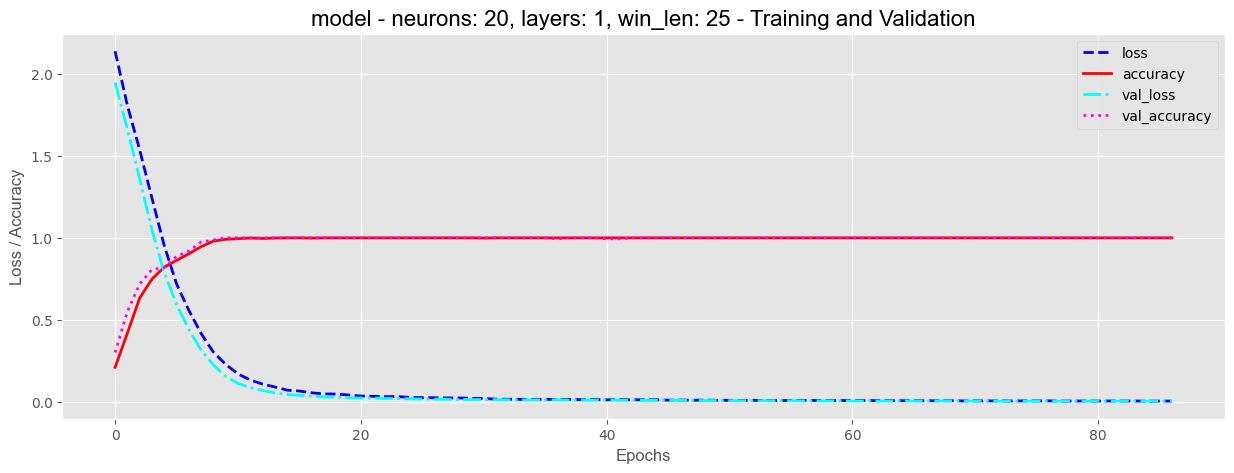

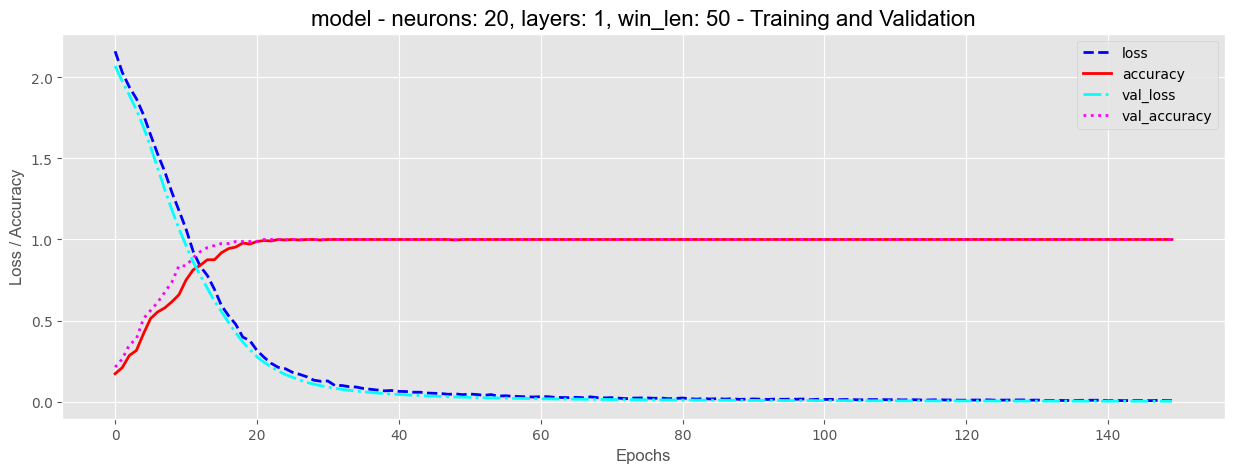

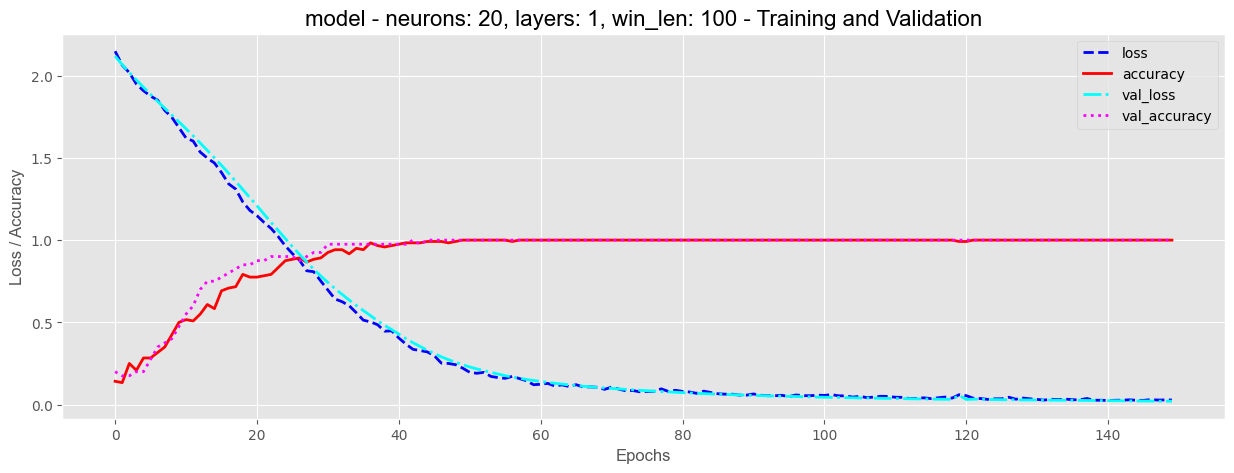

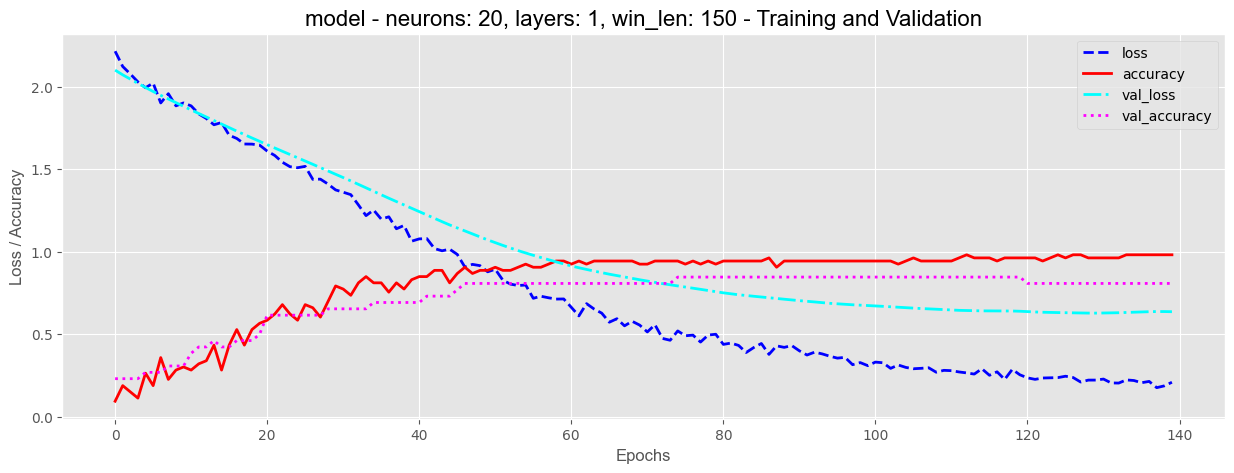

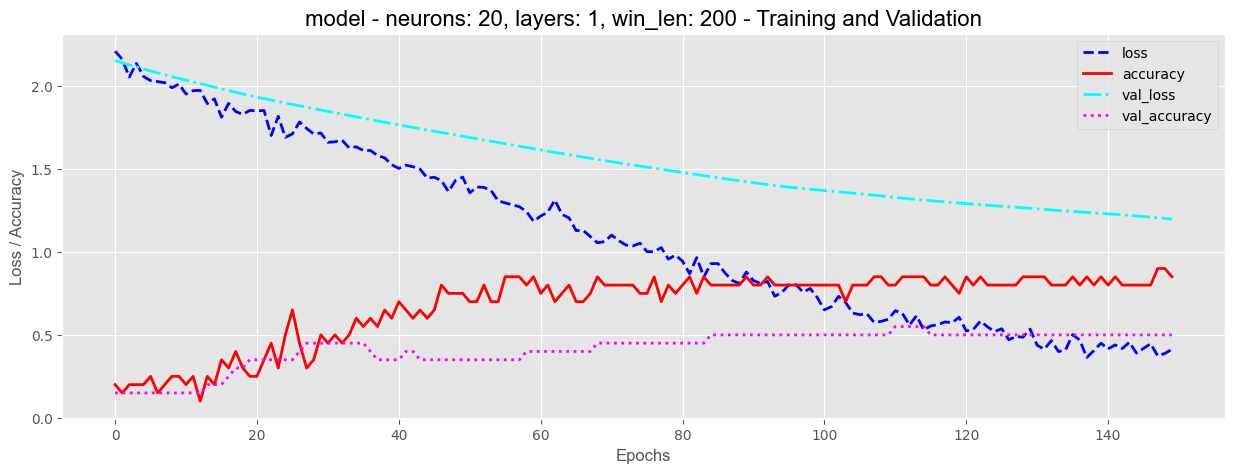

In [110]:
for i, (key, history) in enumerate(histories.items()):
    if i >= 5:
        break
    
    plot_loss_accuracy(history=history, name=key, same_graph=True)

### Accuracy as a function of parameters.

In [111]:
def plot_metrics(metric, is_train=False):
    global training_scores, models, histories

    # Create empty lists to hold max metric values
    max_metric_neurons = []
    max_metric_layers = []
    max_metric_timesteps = []

    # Iterate over models
    for key in models.keys():
        neuron, layer, timestep = parse_key(key)

        if is_train:
            history = training_scores[key]
            max_metric = history[1] if metric == 'accuracy' else history[0]
        else:
            # Get the corresponding history
            history = histories[key]
            # Get the max metric value
            max_metric = max(history[metric])

        # Append max metric value to a corresponding list
        if neuron not in [i[0] for i in max_metric_neurons]:
            max_metric_neurons.append((neuron, max_metric))
        if layer not in [i[0] for i in max_metric_layers]:
            max_metric_layers.append((layer, max_metric))
        if timestep not in [i[0] for i in max_metric_timesteps]:
            max_metric_timesteps.append((timestep, max_metric))

    # Sort lists by neurons/layers/timesteps
    max_metric_neurons.sort(key=lambda x: x[0])
    max_metric_layers.sort(key=lambda x: x[0])
    max_metric_timesteps.sort(key=lambda x: x[0])

    # Create plots
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 3, 1)
    plt.plot([i[0] for i in max_metric_neurons], [i[1] for i in max_metric_neurons])
    plt.title(f'Max {metric} vs Neurons')
    plt.xlabel('Neurons')
    plt.ylabel(f'Max {metric}')

    plt.subplot(1, 3, 2)
    plt.plot([i[0] for i in max_metric_layers], [i[1] for i in max_metric_layers])
    plt.title(f'Max {metric} vs Layers')
    plt.xlabel('Layers')
    plt.ylabel(f'Max {metric}')

    plt.subplot(1, 3, 3)
    plt.plot([i[0] for i in max_metric_timesteps], [i[1] for i in max_metric_timesteps])
    plt.title(f'Max {metric} vs Timesteps')
    plt.xlabel('Timesteps')
    plt.ylabel(f'Max {metric}')

    plt.tight_layout()
    plt.show()


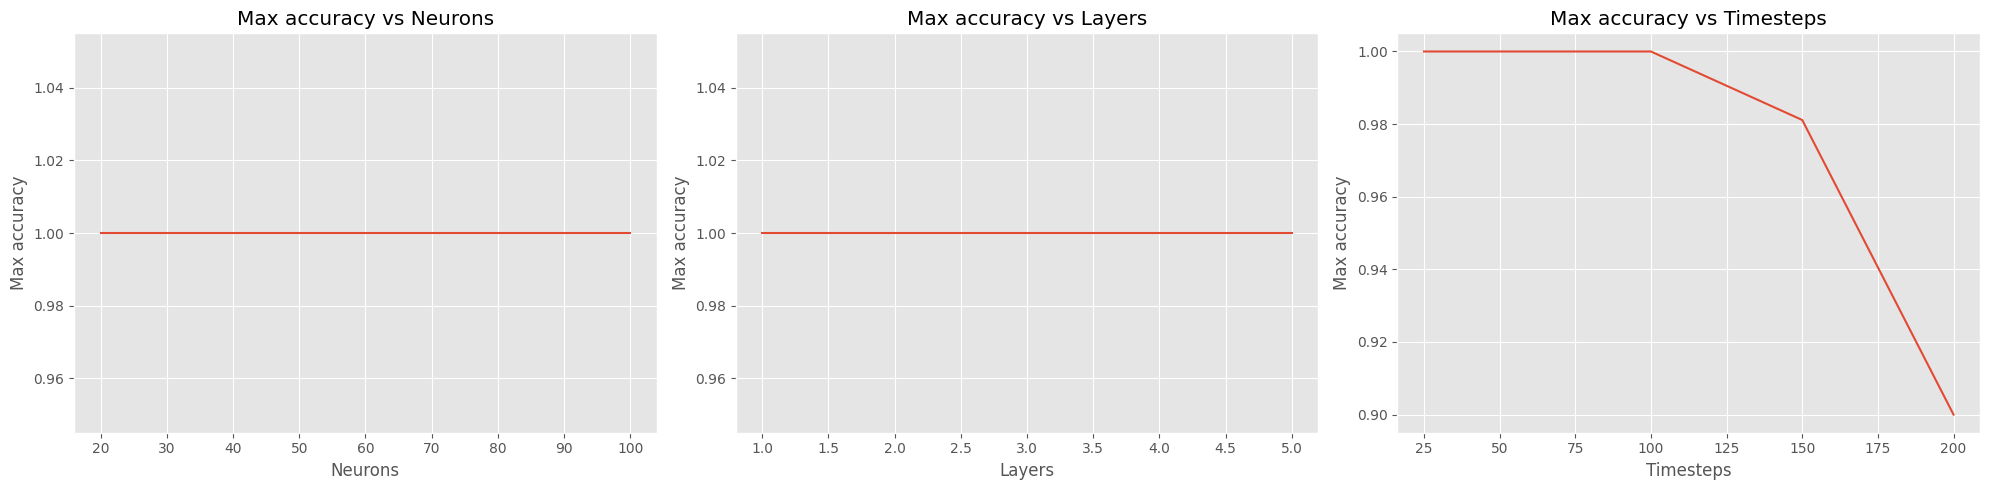

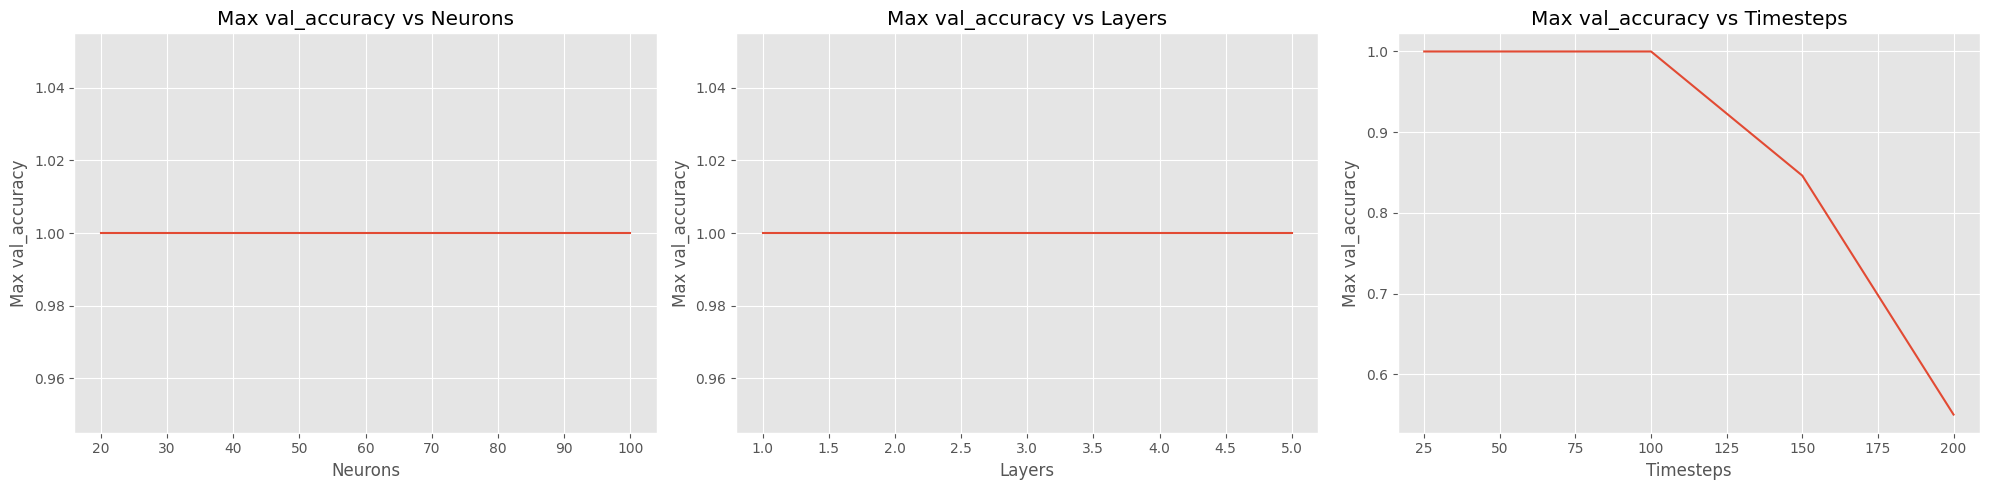

In [112]:
plot_metrics(metric='accuracy')
plot_metrics(metric='val_accuracy')

### Accuracies

In [113]:
%%capture
for key, model in models.items():
    _, _, timestep = parse_key(key)
    _x, _y = test_sets[timestep]
    training_scores[key] = model.evaluate(_x, _y)

### Plot accuracy and loss as a function of each parameter.

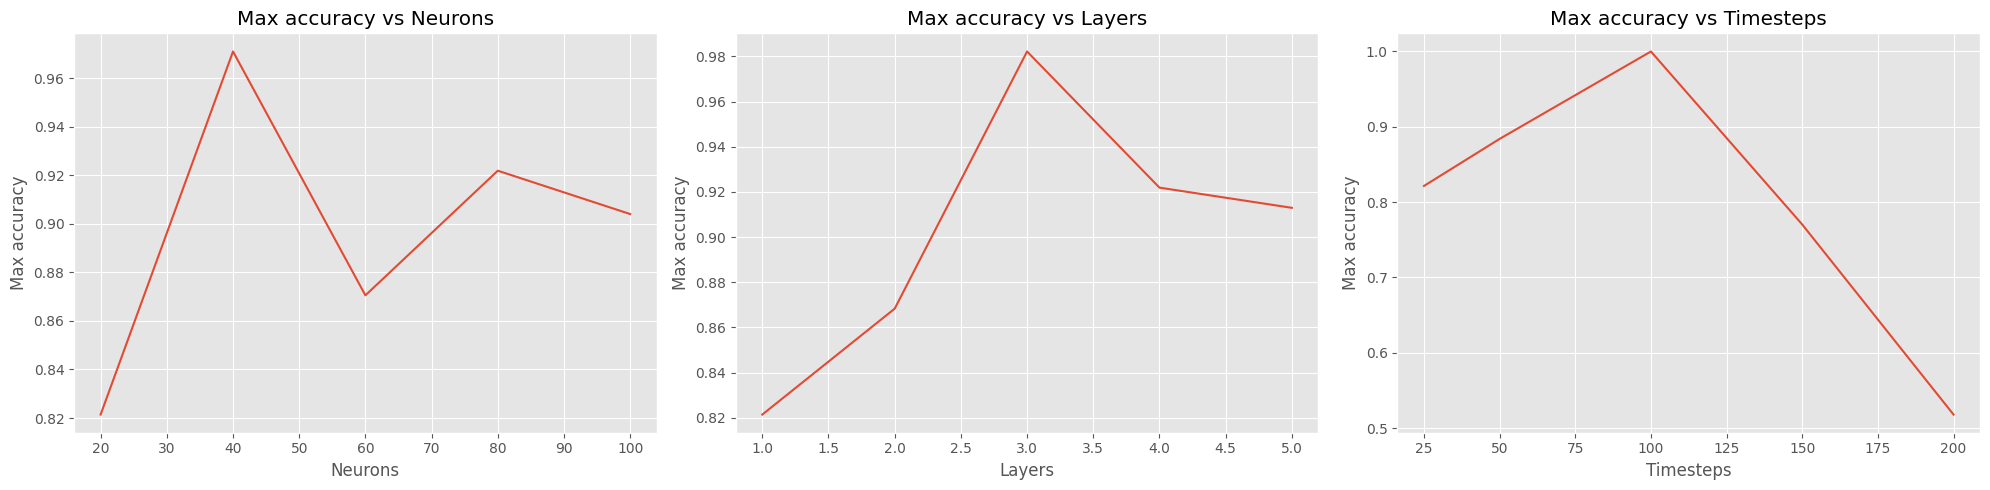

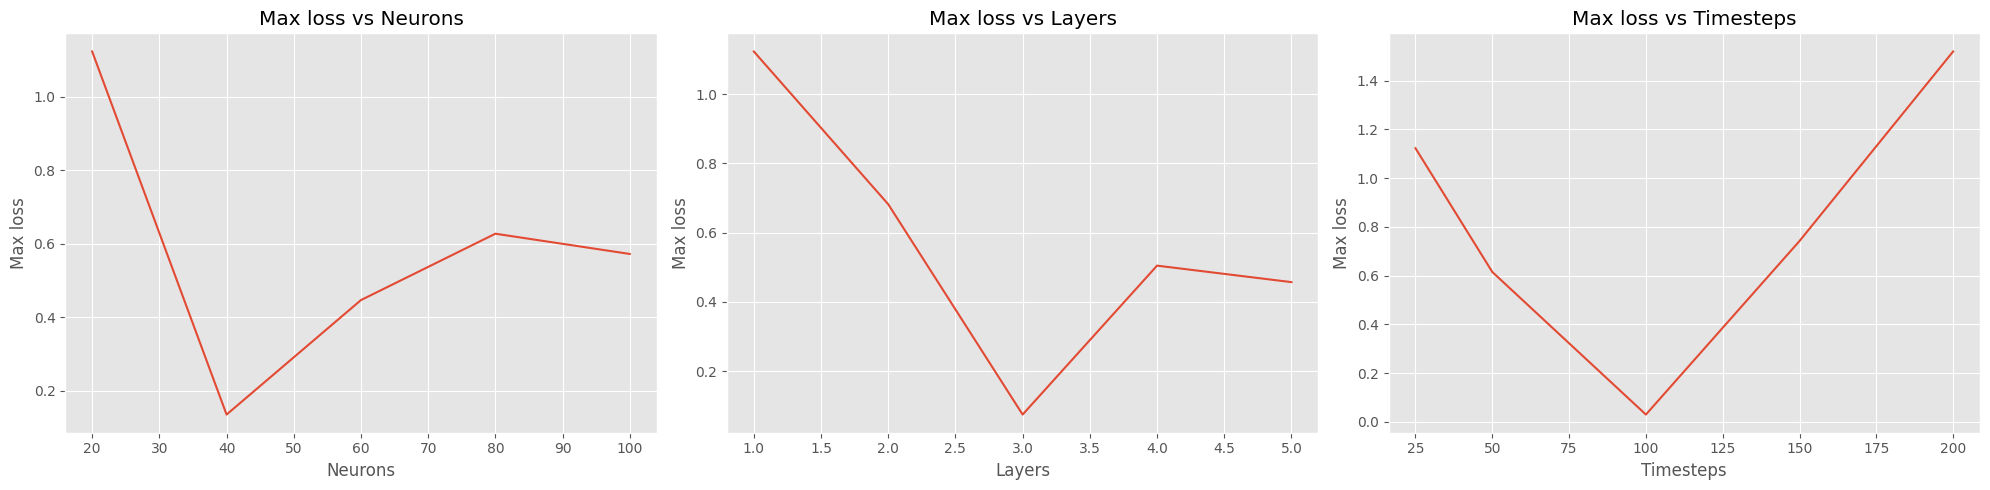

In [114]:
plot_metrics(metric='accuracy', is_train=True)
plot_metrics(metric='loss', is_train=True)

### Predictions

### Training set

14/14 [==============================] - 0s 2ms/step


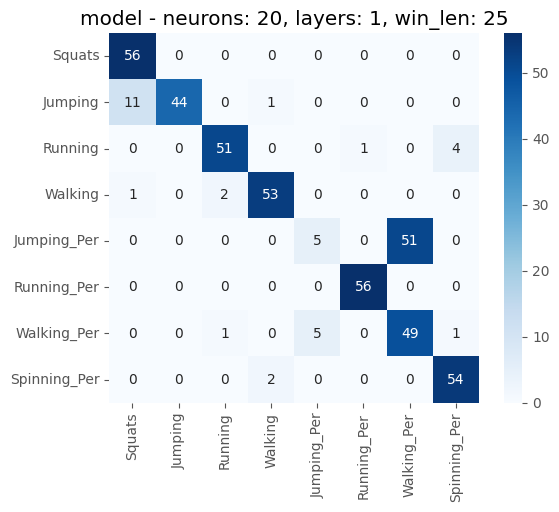

7/7 [==============================] - 0s 4ms/step


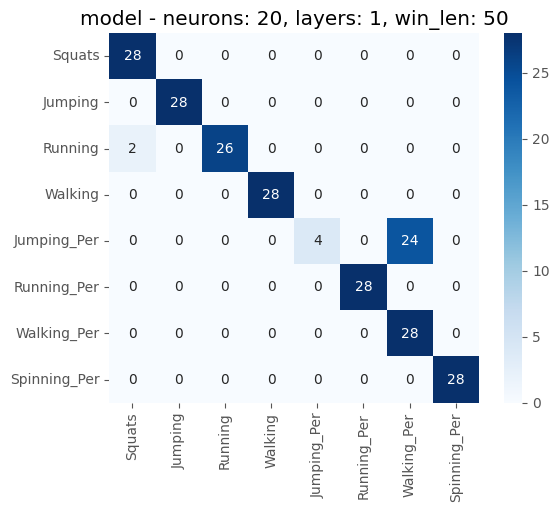

4/4 [==============================] - 0s 6ms/step


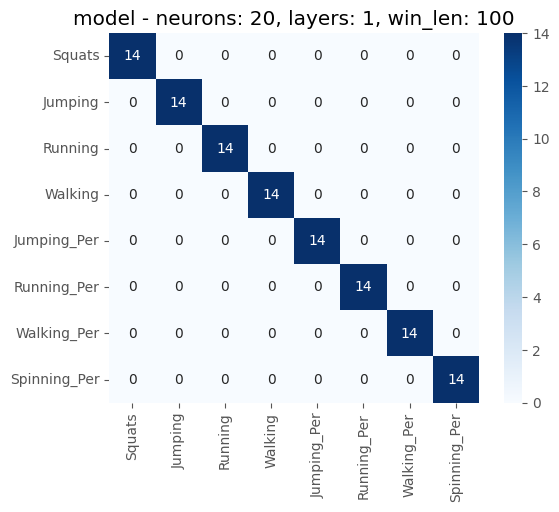

3/3 [==============================] - 0s 8ms/step


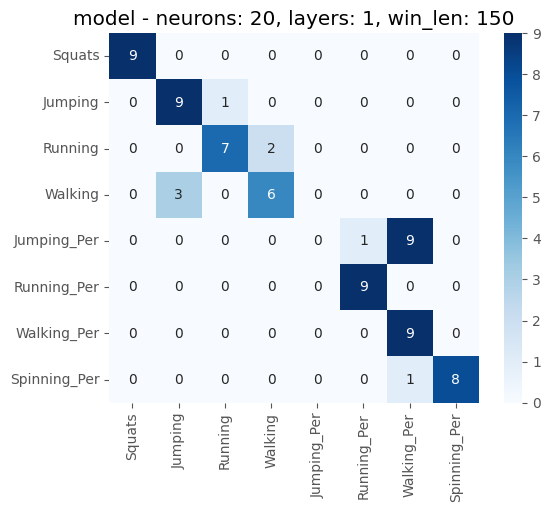

2/2 [==============================] - 0s 11ms/step


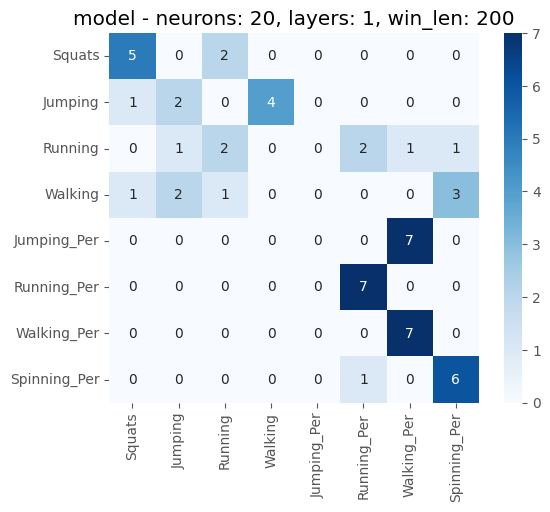

In [115]:
for i, (key, model) in enumerate(models.items()):
    if i >= 5:
        break
        
    _, _, timestep = parse_key(key)
    X_tes, y_tes = test_sets[timestep]

    predicated_probabilities = model.predict(X_tes)

    sns_cm(y_true=  y_tes.argmax(axis=1).flatten(), y_pred= predicated_probabilities.argmax(axis=1).flatten(), labels=classes)
    
    plt.title(key)
    plt.show()

### Raw data training set

In [116]:
# for key, model in models.items():
#     _, _, timestep = parse_key(key)
#     X_tes_1, y_tes_1 = new_datas[timestep]
# 
#     predicated_probabilities = model.predict(X_tes_1)
#     sns_cm(y_true= y_tes_1.argmax(axis=2).flatten(), y_pred= predicated_probabilities.argmax(axis=2).flatten(), labels=classes)
#     plt.title(key)
#     plt.show()